In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed = 855835128

In [2]:
file = pd.read_csv('AgeDataset-V1.csv' )

In [3]:
# file = pd.read_csv(r'E:\Auckland\2022 Semester 2\COMPSCI 760\Assignment\Presentation 2\ModelDf.csv',sep=',',usecols=[3,4,5,8])
#file = pd.read_csv('CleanDf.csv' )
#file = file.dropna()

In [4]:
file.dropna(subset=['Manner of death'], inplace=True) #deleting the null row of manner of death
file.dropna(subset=['Occupation'], inplace=True)
file.dropna(subset=['Gender'], inplace=True)
file.dropna(subset=['Country'], inplace=True)
file.dropna(subset=['Birth year'], inplace=True)
file.dropna(subset=['Short description'], inplace=True)

In [5]:
#NLP
import nltk
import nltk.tokenize as tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string

#For downloading nltk things
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

# Preparing the bag of words
def prepare_bag(df, feature, remove_stops):
    
    result_name = 'preprocessed_' + feature
    
    # Make all letters lower case
    df[result_name] = df[feature].str.lower()
    
    # Remove punctuation
    df[result_name] = df[result_name].str.replace('[{}]'.format(string.punctuation), '', regex=True)
    
    # Remove digits
    df[result_name] = df[result_name].str.replace('[{}]'.format(string.digits), '', regex=True)
    
    # Lemmatize. 
    tknz = tokenize.WhitespaceTokenizer()
    lmtz = stem.WordNetLemmatizer()

    def lemmatize(words):
        return [lmtz.lemmatize(word) for word in tknz.tokenize(words)]
    
    df[result_name] = df[result_name].apply(lemmatize)

    # Remove stopping words if flag true.
    if remove_stops:
        stop = stopwords.words('english')  
        df[result_name] = df[result_name].apply(lambda x: [word for word in x if word not in stop])

    df[result_name] = [TreebankWordDetokenizer().detokenize(x) for x in df[result_name]]

    
# Preprocess bag of words.
prepare_bag(file, 'Short description', True)


[nltk_data] Downloading package wordnet to /home/ubonto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ubonto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubonto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
file.reset_index(drop=True, inplace=True)
file

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death,preprocessed_Short description
0,Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America; Kingdom of Great Bri...,Politician,1732,1799.0,natural causes,67.0,st president united state –
1,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001.0,natural causes,49.0,english writer humorist
2,Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865.0,homicide,56.0,th president united state
3,Q260,Jean-François Champollion,French classical scholar,Male,Kingdom of France; First French Empire,Egyptologist,1790,1832.0,natural causes,42.0,french classical scholar
4,Q296,Claude Monet,French impressionist painter (1840-1926),Male,France,Artist,1840,1926.0,natural causes,86.0,french impressionist painter
...,...,...,...,...,...,...,...,...,...,...,...
45823,Q75349931,John Saxton,British diarist and settler in New Zealand,Male,United Kingdom of Great Britain and Ireland,Settler,1807,1866.0,suicide,59.0,british diarist settler new zealand
45824,Q75717629,Antonín Gruncl,Czechoslovak musician,Male,Czechoslovakia,Artist,1905,1942.0,capital punishment,37.0,czechoslovak musician
45825,Q76161186,Sara Champion,British archaeologist,Female,United Kingdom,Researcher,1946,2000.0,natural causes,54.0,british archaeologist
45826,Q76857201,Dolores Millanes,baaŋa ŋun nyɛ paɣa,Female,Spain,Artist,1859,1906.0,shipwrecking,47.0,baaŋa ŋun nyɛ paɣa


## Gender

In [7]:
file['Gender'].value_counts()

Male                          38476
Female                         7314
Transgender Female               19
Transgender Male                 11
Eunuch; Male                      4
Intersex                          2
Transgender Female; Female        1
Eunuch                            1
Name: Gender, dtype: int64

In [8]:
gender_combine = {'Transgender Female' : 'Diverse', 
                  'Transgender Male': 'Diverse', 
                  'Eunuch; Male' : 'Diverse', 
                  'Transgender Female; Female':'Diverse',
                  'Eunuch':'Diverse', 
                  'Intersex': 'Diverse', 
                 }
file['Gender'] = file['Gender'].replace(gender_combine)
file['Gender'].value_counts()

Male       38476
Female      7314
Diverse       38
Name: Gender, dtype: int64

## Manner of death

In [9]:
file['Manner of death'].value_counts()

natural causes                        31045
suicide                                4508
accident                               4373
homicide                               3273
capital punishment                     1770
                                      ...  
deliberate murder                         1
underwater diving                         1
homicide; accident; natural causes        1
homicide; natural causes                  1
homicide; gas chamber                     1
Name: Manner of death, Length: 177, dtype: int64

(-0.5, 799.5, 499.5, -0.5)

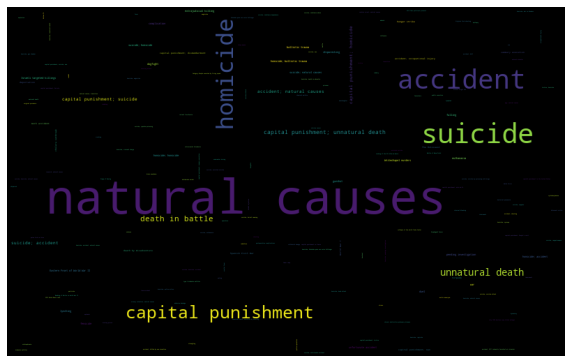

In [10]:
from wordcloud import WordCloud 

MoD = file['Manner of death'].value_counts().to_dict()
freq_death = WordCloud(width =800, height =500, min_font_size=2).generate_from_frequencies(MoD)
plt.figure(figsize=(10,10))
plt.imshow(freq_death)
plt.axis('off')

Making natural causes, accident, suicide, homicide and capital punishment our target label.

In [11]:
file['Manner of death']=file['Manner of death'].astype(str)
file['Manner of death']=file['Manner of death'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Manner of death'].value_counts()

natural causes                  31046
suicide                          4560
accident                         4408
homicide                         3305
capital punishment               1899
                                ...  
epidemic                            1
Holocaust victim                    1
chemical warfare                    1
2010 Thai political protests        1
sleep apnea                         1
Name: Manner of death, Length: 123, dtype: int64

Feature engineering

In [12]:
#only getting the top 5 deaths
deaths = ['natural causes' ,'suicide', 'homicide', 'accident', 'capital punishment']
file = file[file['Manner of death'].isin(deaths)]

<AxesSubplot:title={'center':'Percentage of manner of deaths'}, ylabel='Count'>

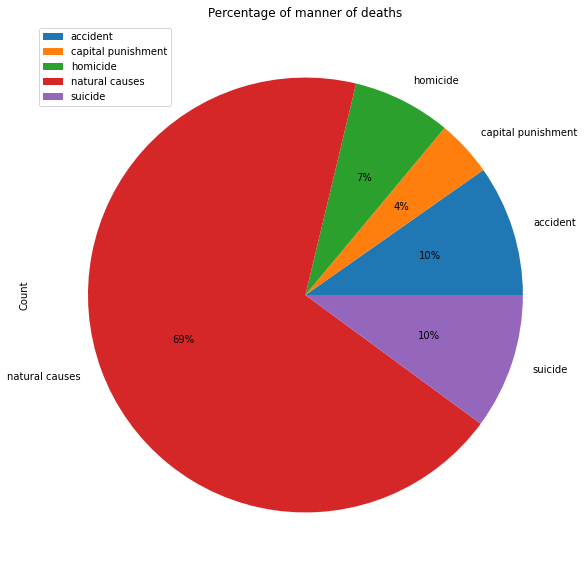

In [13]:
#pie chart for manner of death
#class imbalance
Manner_of_death = file[['Manner of death']].groupby(['Manner of death']).size().reset_index(name='Count').sort_values('Count', ascending = False)
Manner_of_death.groupby(['Manner of death']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%',title='Percentage of manner of deaths', figsize=(15, 10))

<AxesSubplot:xlabel='Age of death', ylabel='Manner of death'>

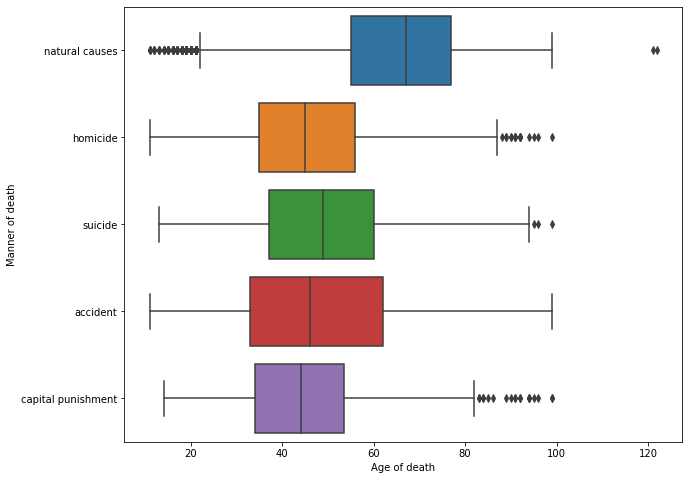

In [14]:
plt.figure(figsize=(10,8))
sns.boxplot(data=file, x='Age of death', y = 'Manner of death')

<AxesSubplot:xlabel='Gender', ylabel='Birth year'>

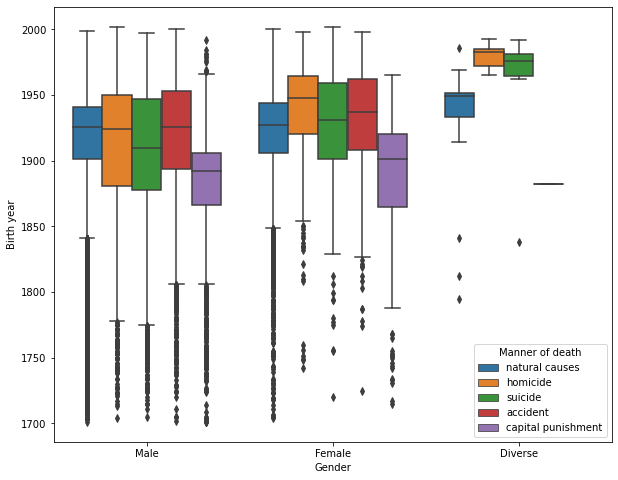

In [15]:
plt.figure(figsize=(10,8))
sns.boxplot(data=file[file['Birth year']>1700], x='Gender', y = 'Birth year',hue='Manner of death')

## Occupation

In [16]:
file = file.assign(Occupation=lambda d: d['Occupation'].astype(str))
file['Occupation']=file['Occupation'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
occu = file['Occupation'].value_counts()
top_occupation = occu.head(10)
top_occupation

Artist                17926
Politician             7163
Athlete                5621
Researcher             2675
Military personnel     1984
Journalist              920
Businessperson          747
Religious figure        674
Teacher                 394
Engineer                305
Name: Occupation, dtype: int64

## Country

In [17]:
file = file.assign(Country=lambda d: d['Country'].astype(str))
file['Country']=file['Country'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Country'].value_counts()

United States of America    17549
United Kingdom               3353
France                       2634
Germany                      1826
Canada                       1401
                            ...  
Zhao                            1
French Polynesia                1
Umayyad dynasty                 1
Benin                           1
Colombiana                      1
Name: Country, Length: 457, dtype: int64

In [18]:
# pd.crosstab(file['Manner of death'],file['Occupation'],normalize='index').plot.bar(stacked=True)

<AxesSubplot:xlabel='Manner of death'>

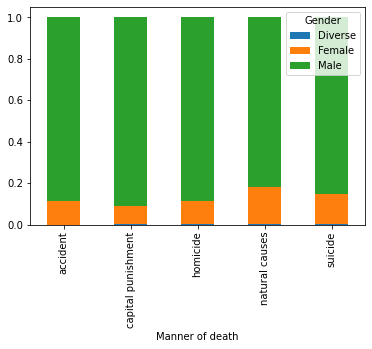

In [19]:
pd.crosstab(file['Manner of death'],file['Gender'],normalize='index').plot.bar(stacked=True)

In [20]:
file.reset_index(drop=True, inplace=True)

## Hyper parameter tuning

In [21]:
file

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death,preprocessed_Short description
0,Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America,Politician,1732,1799.0,natural causes,67.0,st president united state –
1,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001.0,natural causes,49.0,english writer humorist
2,Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865.0,homicide,56.0,th president united state
3,Q260,Jean-François Champollion,French classical scholar,Male,Kingdom of France,Egyptologist,1790,1832.0,natural causes,42.0,french classical scholar
4,Q296,Claude Monet,French impressionist painter (1840-1926),Male,France,Artist,1840,1926.0,natural causes,86.0,french impressionist painter
...,...,...,...,...,...,...,...,...,...,...,...
45213,Q75336010,George Dewey Sanford Jr.,United States Marine,Male,United States of America,Military personnel,1925,1994.0,suicide,69.0,united state marine
45214,Q75349931,John Saxton,British diarist and settler in New Zealand,Male,United Kingdom of Great Britain and Ireland,Settler,1807,1866.0,suicide,59.0,british diarist settler new zealand
45215,Q75717629,Antonín Gruncl,Czechoslovak musician,Male,Czechoslovakia,Artist,1905,1942.0,capital punishment,37.0,czechoslovak musician
45216,Q76161186,Sara Champion,British archaeologist,Female,United Kingdom,Researcher,1946,2000.0,natural causes,54.0,british archaeologist


In [22]:
#combining all words into single column for bag of words
file = file.assign(Birth_year=lambda d: d['Birth year'].astype(str))
file['Combined_words'] = file['Gender'] + ' ' + file['Country'] + ' ' + file['Occupation'] + ' ' + file['Birth_year'] + ' ' + file['preprocessed_Short description']

In [23]:
target = file['Manner of death'] #decreased the labels to 5 
data = file[['Gender','Occupation','Country','Birth year']]

In [24]:
target.nunique()

5

In [25]:
file.isnull().sum()

Id                                0
Name                              0
Short description                 0
Gender                            0
Country                           0
Occupation                        0
Birth year                        0
Death year                        0
Manner of death                   0
Age of death                      0
preprocessed_Short description    0
Birth_year                        0
Combined_words                    0
dtype: int64

In [26]:
# pre-processing data
data_T = data.T
arr1 = data_T.to_numpy()
temp = np.zeros((4,len(data)))
le1 = preprocessing.LabelEncoder()
for i in range(len(arr1)):
    le1.fit(arr1[i])
    temp[i] = le1.transform(arr1[i])
x_T = pd.DataFrame(temp)
x = x_T.T
x = x.to_numpy()

arr2 = target.to_numpy()
le2 = preprocessing.LabelEncoder()
le2.fit(arr2)
y = le2.transform(arr2)
# The result of pre-processing
print("The feature vectors:\n",x)
print("The predictive vector:\n",y)

The feature vectors:
 [[  2. 582. 430. 707.]
 [  2.  46. 428. 927.]
 [  2. 582. 430. 784.]
 ...
 [  2.  46.  85. 880.]
 [  1. 647. 428. 921.]
 [  2. 471. 430. 814.]]
The predictive vector:
 [3 3 2 ... 1 3 2]


In [27]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
x_1 = vectorizer.fit_transform(file['Combined_words'])
x = x_1.toarray()

In [28]:
#stratified Kfold for imbalance class
skf = StratifiedKFold(n_splits = 2, random_state = seed, shuffle = True)
skf.get_n_splits(x,y)

for train, test in skf.split(x, y):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = seed)

In [30]:
# calculate Gini and Enrtopy
DT = DecisionTreeClassifier(random_state = seed)
score = cross_val_score(DT,x_train,y_train,cv=5).mean()
print('Gini: %.4f'%score)
DT = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
score = cross_val_score(DT,x_train,y_train,cv=5).mean()
print('Entropy: %.4f'%score)

KeyboardInterrupt: 

Entropy is better than Gini in this data set.

In [ ]:
ScoreAll = []
for i in range(1,50,5):
    DT = DecisionTreeClassifier(max_depth = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x_train,y_train,cv = 5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [ ]:
ScoreAll = []
for i in range(1,10):
    DT = DecisionTreeClassifier(max_depth = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x_train,y_train,cv = 5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [ ]:
# consider min_samples_split
ScoreAll = []
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth = 3, min_samples_split = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x_train,y_train,cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize = [20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

There is no need to modify the min_samples_split parameter.

In [ ]:
# consider min_samples_leaf
ScoreAll = []
for i in range(1,30):
    DT = DecisionTreeClassifier(min_samples_leaf = i, min_samples_split = 2,max_depth = 3,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x_train,y_trainx_train,y_train,cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize = [20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [ ]:
# Entropy,max_depth = 3, min_samples_leaf = 1, min_samples_split = 2
param_grid = {
    'max_depth':np.arange(1,10),
    'min_samples_leaf':np.arange(1,10),
    'min_samples_split':np.arange(2,10)
}
DTC = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
GS = GridSearchCV(DTC,param_grid,cv=5)
GS.fit(x_train,y_train)
print(GS.best_params_)
print(GS.best_score_)

In [31]:
DT = DecisionTreeClassifier(max_depth= 7, min_samples_leaf= 7, min_samples_split= 2)

DTClass = DT.fit(x_train,y_train)

train_score = DTClass.score(x_train, y_train)
print('Accuracy on train set: {:.3f}%'.format(train_score * 100))

test_score = DTClass.score(x_test, y_test)
print('Accuracy on test set: {:.3f}%'.format(test_score * 100))

Accuracy on train set: 69.530%
Accuracy on test set: 69.149%


In [32]:
#getting features picked by decision tree
decision_feature_importatnt = pd.DataFrame(
                                    data=DTClass.feature_importances_,
                                    columns=['importance'],
                                    index= vectorizer.get_feature_names(),
                                    ).sort_values(by=['importance'], ascending=False)

In [33]:
dcfeature = decision_feature_importatnt[decision_feature_importatnt['importance'] > 0] #disregarding not used features

(-0.5, 799.5, 499.5, -0.5)

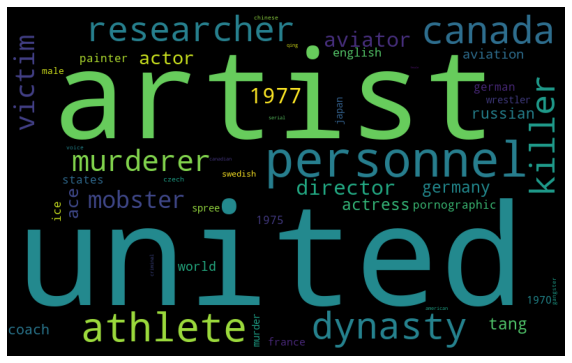

In [34]:
freq_death = WordCloud(width =800, height =500, min_font_size=2).generate_from_frequencies(dcfeature['importance'].to_dict())
plt.figure(figsize=(10,10))
plt.imshow(freq_death)
plt.axis('off')

In [35]:
from sklearn.metrics import roc_curve, auc
false_positive, true_positive, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

NameError: name 'y_prob' is not defined